# K-means

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

df = pd.read_csv("/Users/giovanni-lunetta/stat_4185/final/past_ten_seasons/data/cleaned.csv")

In [4]:
df.columns

Index(['Player', 'ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'Age',
       'G', 'GS', 'FG', 'FGA', '2P', '2PA', '3P', '3PA', 'FT', 'FTA', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'FG%', '2P%',
       '3P%', 'FT%', 'TS%', 'eFG%', 'Pos', 'MP'],
      dtype='object')

Here we scale the basketball slills that we want to use in the analysis.

In [5]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# X = df[['ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', '2P', '2PA', '3P', '3PA', 'FT', 'FTA', 'PTS', 'FG%', '2P%',
#        '3P%', 'FT%', 'TS%', 'eFG%']]

X = df[['ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', '2P', '2PA', '3P', '3PA', 'FT', 'FTA', 'PTS']]

# Create a StandardScaler object
scaler = StandardScaler()

# Apply the scaler to the selected variables
X_scaled = scaler.fit_transform(X)

In [6]:
X.head()

,ORB%,DRB%,AST%,STL%,BLK%,TOV%,USG%,2P,2PA,3P,3PA,FT,FTA,PTS
0,12.7,24.3,8.0,0.8,3.8,14.3,16.6,6.1,10.0,0.0,0.0,3.0,4.1,15.2
1,10.7,22.4,6.6,0.7,2.3,13.0,18.2,6.5,11.2,0.0,0.0,3.0,4.3,16.0
2,1.8,15.1,7.0,1.0,1.6,14.6,14.8,2.1,5.3,1.5,4.5,1.1,1.4,9.9
3,9.6,18.5,8.1,0.7,2.7,11.8,17.8,5.7,11.2,0.0,0.2,2.7,3.5,14.3
4,9.8,19.9,9.9,1.4,2.5,12.6,17.0,5.1,9.5,0.1,0.5,3.3,4.5,13.8


In [7]:
# # Split the PCA-transformed data into training and testing sets
# X_train, X_test = train_test_split(X_scaled, test_size=0.3, random_state=42)

Next I attempt to find the optimal number of clusters using the elbow method and then a variation of the elbow method. I decided that the optimal number of clusters was 8.

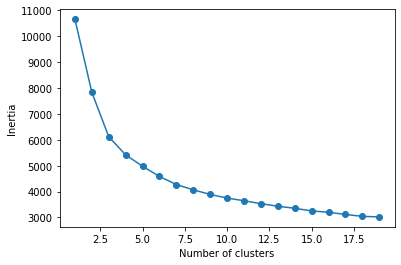

In [8]:
# Find the optimal number of clusters using the elbow method
n_clusters = np.arange(1, 20)
inertia_scores = []

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(X_scaled)
    inertia_scores.append(kmeans.inertia_)

plt.plot(n_clusters, inertia_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

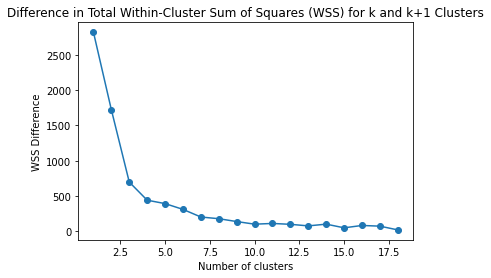

In [9]:
wss_difference = np.diff(inertia_scores) * -1

plt.plot(n_clusters[:-1], wss_difference, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WSS Difference')
plt.title('Difference in Total Within-Cluster Sum of Squares (WSS) for k and k+1 Clusters')
plt.show()

Now we can use kmeans with 8 clusters.

In [10]:
# Choose the optimal number of clusters based on your analysis
optimal_n_clusters = 8  # Modify this value based on the elbow method

kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
kmeans.fit(X_scaled)
cluster_labels = kmeans.predict(X_scaled)
# cluster_labels_test = kmeans.predict(X_test)

In [11]:
X_original = pd.DataFrame(X_scaled, columns=X.columns)

We can also look at the center of the clusters for each variable in order to see differences among clusters and the variables.

In [12]:
import seaborn as sns

# Get cluster centers and convert them back to the original scale
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

# Create a DataFrame with cluster centers and features
centers_df = pd.DataFrame(cluster_centers, columns=X.columns)
centers_df['Cluster'] = centers_df.index + 1  # Add cluster labels starting from 1

# Melt the DataFrame into a long format for easier plotting
centers_melted = centers_df.melt(id_vars='Cluster', var_name='Feature', value_name='Value')

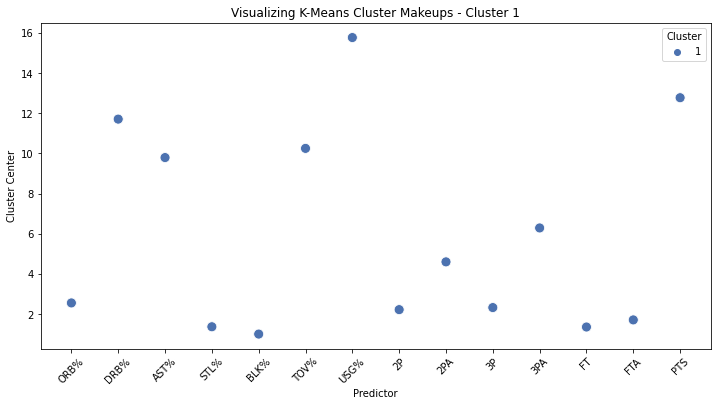

In [13]:
plt.figure(figsize=(12, 6))  # Adjust the width and height of the plot
sns.scatterplot(data=centers_melted[centers_melted['Cluster'] == 1], x='Feature', y='Value', hue='Cluster', palette='deep', s=100)
plt.xticks(rotation=45)
plt.title("Visualizing K-Means Cluster Makeups - Cluster 1")
plt.xlabel("Predictor")
plt.ylabel("Cluster Center")
plt.legend(title='Cluster', loc='upper right')
plt.show()

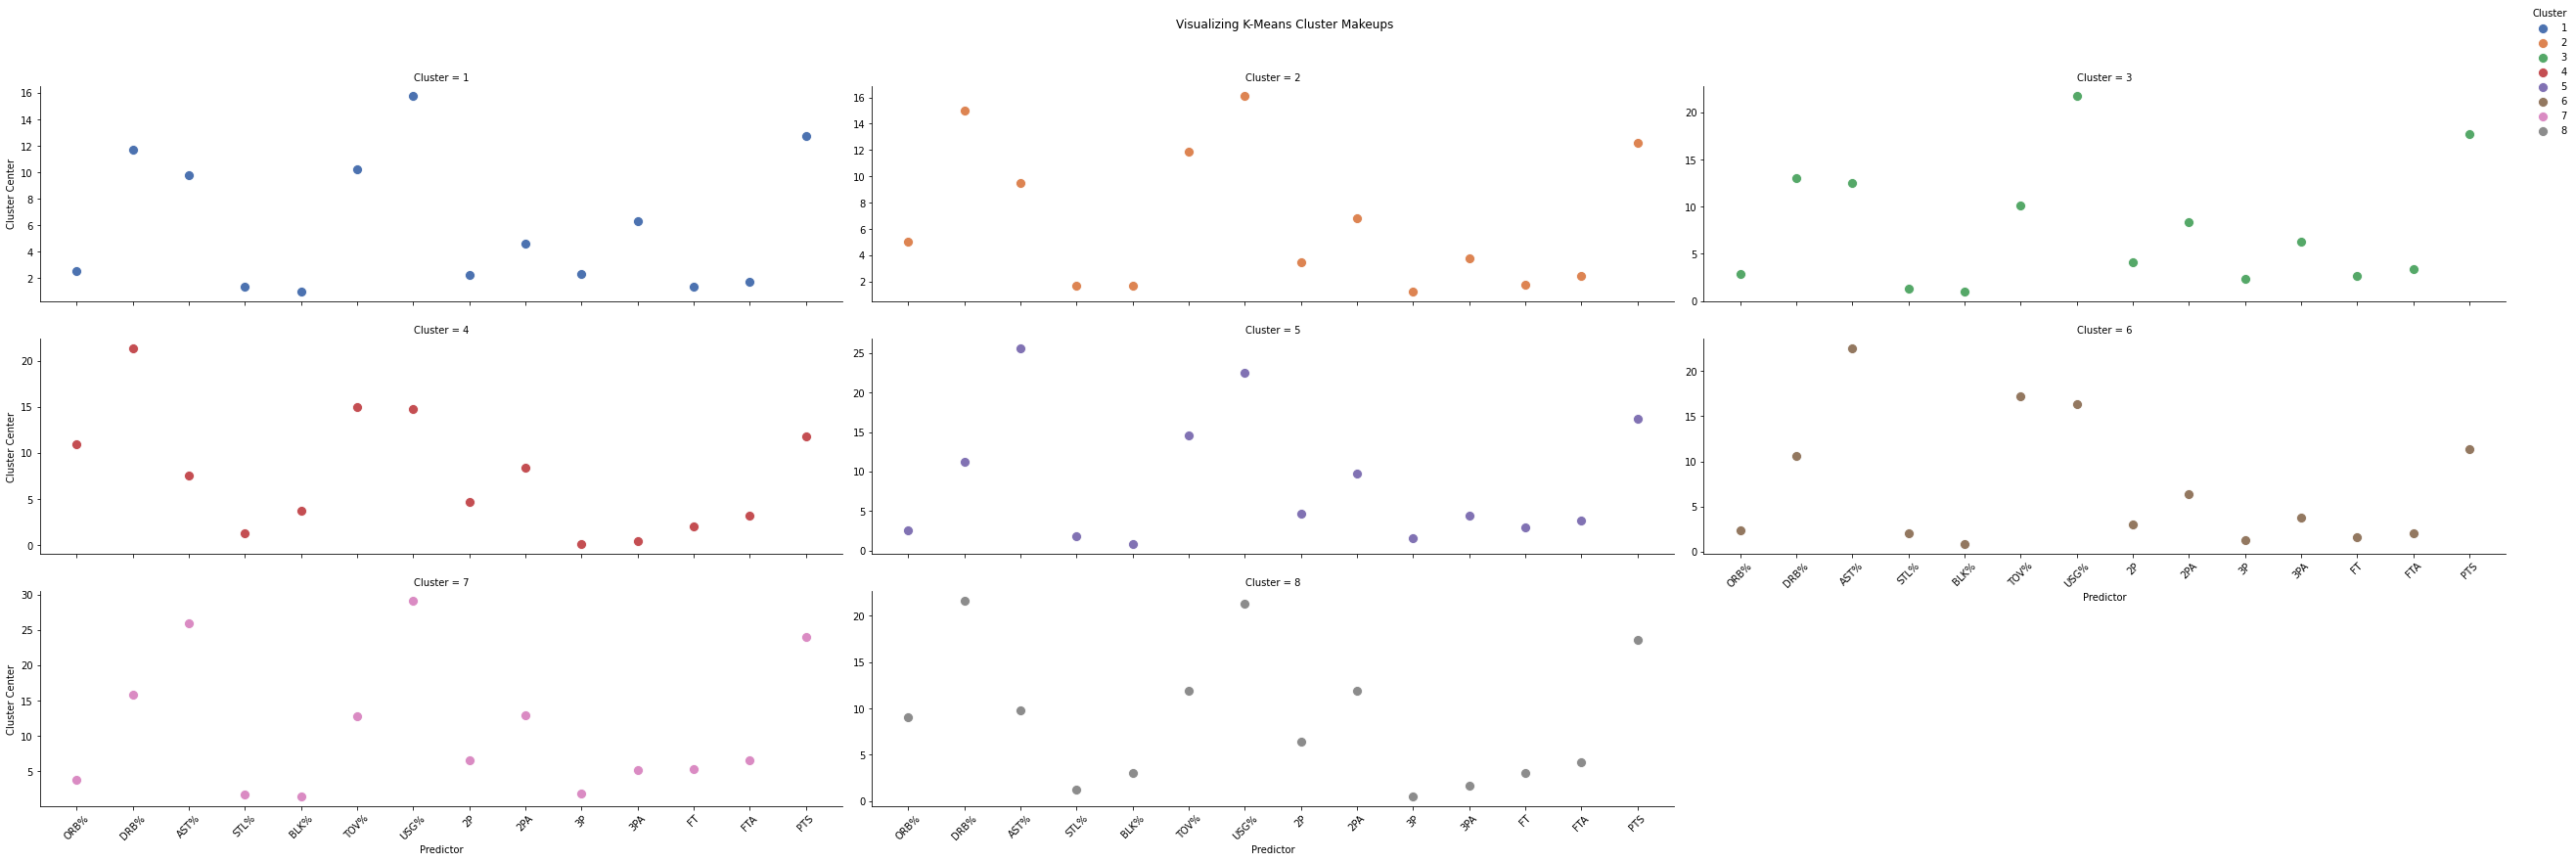

In [14]:
g = sns.FacetGrid(centers_melted, col='Cluster', col_wrap=3, hue='Cluster', palette='deep', sharey=False, height=4, aspect=3)
g.map_dataframe(sns.scatterplot, x='Feature', y='Value', s=100)
g.set_xticklabels(rotation=45)

g.set_axis_labels("Predictor", "Cluster Center")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Visualizing K-Means Cluster Makeups")
g.add_legend(title='Cluster', loc='upper right')

plt.show()

Next, we can get the player names associated with each cluster to analyze.

In [15]:
# Add cluster labels to the original dataset
df['Cluster (kmeans)'] = kmeans.labels_

# View the players in each cluster
for i in range(optimal_n_clusters):
    print(f"Players in Cluster {i+1}:")
    print(df[df['Cluster (kmeans)'] == i]['Player'].values)
    print()

Players in Cluster 1:
['Paul Zipser' 'Dorell Wright' 'Ziaire Williams' 'Shawne Williams'
 'Marvin Williams' 'Grant Williams' 'Martell Webster' 'Yuta Watanabe'
 'Ish Wainright' 'Dean Wade' 'Sasha Vujačić' 'Gabe Vincent'
 'Rashad Vaughn' 'Denzel Valentine' 'Anthony Tolliver' 'Hollis Thompson'
 'Jason Terry' 'Garrett Temple' 'Mirza Teletović' 'Max Strus'
 'Nik Stauskas' 'Tony Snell' 'J.R. Smith' 'Landry Shamet' 'Mike Scott'
 'John Salmons' 'Brandon Rush' 'Terrence Ross' 'Jerome Robinson'
 'Duncan Robinson' 'Austin Rivers' 'Chasson Randle' 'Payton Pritchard'
 'A.J. Price' 'Quincy Pondexter' 'Patrick Patterson' 'Cedi Osman'
 'Chuma Okeke' 'Semi Ojeleye' "Royce O'Neale" 'Steve Novak'
 'Georges Niang' 'Aaron Nesmith' 'Svi Mykhailiuk' 'Mike Muscala'
 'Trey Murphy III' 'Mychal Mulder' 'Anthony Morrow' 'Monte Morris'
 'Moses Moody' 'Davion Mitchell' 'Patty Mills' 'Mike Miller'
 'Darius Miller' 'Nicolò Melli' 'Ben McLemore' 'Rodney McGruder'
 'Doug McDermott' 'Wesley Matthews' 'Garrison Mathews' 

Finally, we can visualize these differences among variables in three different charts that all essentially show the same thing but have different levels of interpretability.

In [16]:
# features = ['ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', '2P', '2PA', '3P', '3PA', 'FT', 'FTA', 'PTS', 'FG%', '2P%',
#        '3P%', 'FT%', 'TS%', 'eFG%']

features = ['ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', '2P', '2PA', '3P', '3PA', 'FT', 'FTA', 'PTS']

mean_values = df.groupby('Cluster (kmeans)')[features].mean()

In [17]:
from math import pi

def create_radar_chart(mean_values, features, clusters):
    # Set the number of variables and calculate the angle for each axis
    num_vars = len(features)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    # Set the radar chart figure
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    # Set the first axis on top and move clockwise
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw axis lines and labels
    plt.xticks(angles[:-1], features)
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="gray", size=8)
    plt.ylim(0, 1)

    # Normalize the mean values to the range [0, 1]
    normalized_values = mean_values / mean_values.max().max()

    # Plot the radar chart for each cluster
    for i in range(clusters):
        values = normalized_values.iloc[i].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=f"Cluster {i}")
        ax.fill(angles, values, alpha=0.25)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title("Mean values by attribute for each cluster")
    plt.show()

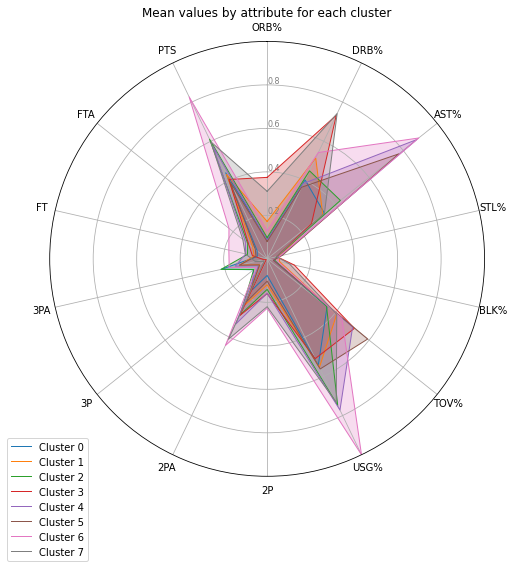

In [18]:
# Call the function to create the radar chart
create_radar_chart(mean_values, features, optimal_n_clusters)

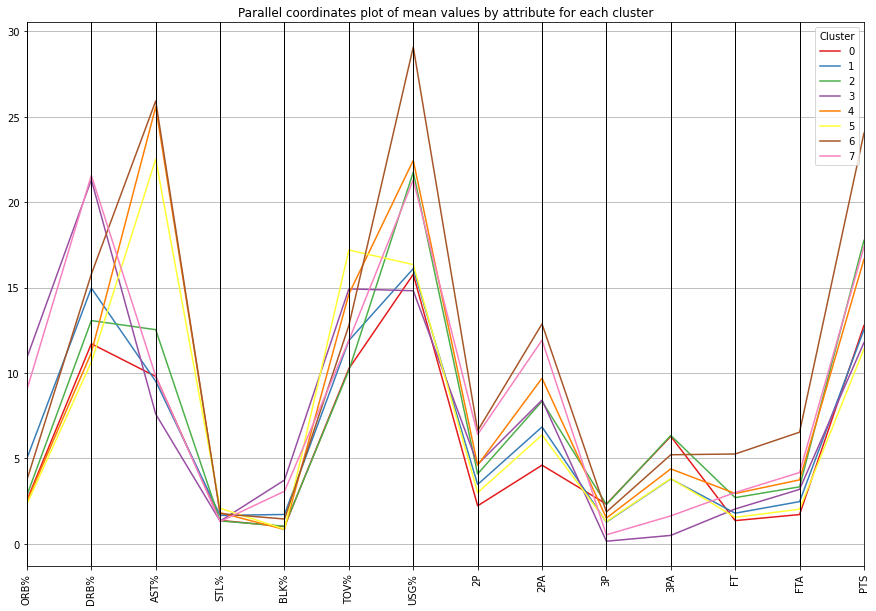

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

def create_parallel_coordinates_plot(mean_values, features, clusters):
    # Create a new DataFrame with the cluster labels and mean values
    mean_values['cluster'] = mean_values.index
    mean_values = mean_values.reset_index(drop=True)

    # Set up the plot
    plt.figure(figsize=(15, 10))

    # Plot the parallel coordinates plot using pd.plotting.parallel_coordinates()
    pd.plotting.parallel_coordinates(mean_values, 'cluster', color=plt.cm.Set1.colors)

    # Customize the plot
    plt.title("Parallel coordinates plot of mean values by attribute for each cluster")
    plt.xticks(range(len(features)), features, rotation=90)
    plt.legend(title='Cluster', loc='upper right')

create_parallel_coordinates_plot(mean_values, features, optimal_n_clusters)
plt.show()


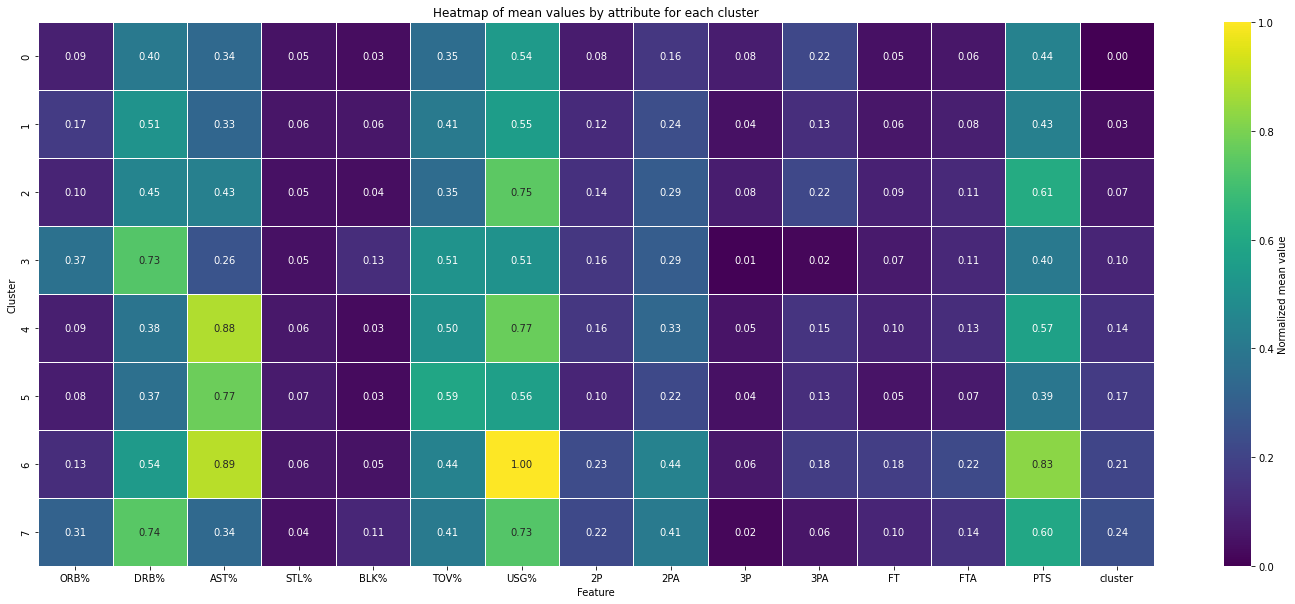

In [20]:
def create_heatmap(mean_values, features, clusters):
    # Normalize the mean values to the range [0, 1]
    normalized_values = mean_values / mean_values.max().max()

    # Plot the heatmap
    plt.figure(figsize=(25, 10))
    sns.heatmap(normalized_values, cmap="viridis", annot=True, fmt=".2f", linewidths=.5, cbar_kws={'label': 'Normalized mean value'})
    plt.title("Heatmap of mean values by attribute for each cluster")
    plt.xlabel("Feature")
    plt.ylabel("Cluster")
    plt.show()

# Call the function to create the heatmap
create_heatmap(mean_values, features, optimal_n_clusters)

Next we try kmeans with PCA dimension reduction.

Conclusions in README